# Storm Identification and Data Collocation

This notebook reads the data produced by radiative convective equilibirum (RCE) simulations. A range of analyses are then performed, from simpler calculations of convective available potential energy (CAPE) to more demanding clustering routines. The fields of all these analyses are then combined together, in xr array structure, for ease of access and comprehension. Finally, the environmental variables are then collocated with the identified clusters, corresponding to storms.

This notebook sets out the necessary functions and then the final compilation function, outputting the combined data.

### Imports and Warnings
Necessary libraries are imported and warnings disabled

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from scipy import ndimage
import random
import scipy 
from dask.distributed import Client, progress, wait

import warnings
warnings.filterwarnings(action='ignore')

### Client Details
Information is called concerning the dask set up

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 1
Total threads: 1,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39117,Workers: 1
Dashboard: http://127.0.0.1:8787/status,Total threads: 1
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:43625,Total threads: 1
Dashboard: http://127.0.0.1:45432/status,Memory: 32.00 GiB
Nanny: tcp://127.0.0.1:45938,


### Constants
Important physical constants are given here

In [3]:
g = 9.81
MWw = 0.01802 # kg mol-1
MWa = 0.02897 # kg mol-1
rho_air = 1.3 # kg m-3
rho_water = 1000 # kg m-3
eps = MWw/MWa

### Functions

In [4]:
def sst_file_opener(sst):
    #Opens a directory of files, each with different time steps, corresponding to a single sea surface temperature (sst).
    #Each time step has netcdf data in x,y,z. The output is a joined dataset in time,x,y,z, for a single sst.
    
    #numerical sst value cast into string
    sst_str = str(sst)
    
    #path created
    path = '/xdisk/sylvia/RCE-CAPE-exploration/RCE-sims/ch_cam' + sst_str +'ri0/'
    
    #dataset created,combining different timesteps in the sst directory
    dataset = xr.open_mfdataset(path+'ch_cam'+sst_str+'ri0_4096x64x64_3km_12s_cam'+sst_str+'ri0_64_*.nc',combine='by_coords')

    return dataset

def precipConversion(qp):
    #Function to convert QP to precipitation intensity in units of mm per hour
    
    rho_air = 1.3  # [kg m-3 air] Technically this should account for altitude dependence
    rho_liq = 1000 # [kg m-3 liq water / rain]
    del_t   = 0.5  # [h] Temporal resolution of the RCE sims
    del_x   = 3000 # [m] Spatial resolution of the RCE sims

    # Calculate rain rate [m h-1] and return a value in [m h-1]
    # Why do I multiply by del_x**2 rather than dividing? 
    # Assume 1 m3 of air and 1 m3 of rain. The rain is then distributed over a grid cell of area del_x**2 at some rate.
    rr = qp * rho_air / rho_liq / del_t * del_x**2
    
    # Final factor of 1000 here converst [m h-1] to [mm h-1]
    return rr / 1000

def storm_labeller(binary_t_xr):
    #Function that takes in a binary structure in 3d (time,x and y) and which finds spatially connected
    #components in each time step, i.e. identifies clusters without using temporal connectivity
    
    #Connectivity employed is 4 connectivity
    
    #creating connected components structure for ndimage
    #no temporal connection between clusters, so empty 0th and 2nd array
    struct = np.zeros((3,3,3))

    #simple 4 connection within current time set
    struct[1] = [[0,1,0],[1,1,1],[0,1,0]]

    #labels_0 is array of clusters with unique numerical labels
    #nb_0 is number of identified clusters
    labels_0,nb_0 = ndimage.label(binary_t_xr,structure=struct)

    #find the sizes of each object, in terms of pixels 
    pixelsizes = ndimage.sum(binary_t_xr,labels_0,range(nb_0+1))

    #create a boolean array for whether the objects 
    #are larger than a given threshold
    #the threshold was set to 310 by Paul but I think it should be 706 for an eq diameter of 90 km
    mask_size = pixelsizes < 705

    #indices of pixels to be removed are produced
    remove_pixel = mask_size[labels_0]
  
    #indices and thus objects are removed based on object size
    labels_0[remove_pixel] = 0
    
    labels_0 = xr.where(labels_0==0,np.nan,labels_0)
    
    #cluster array cast into xr array
    labelled_xr = xr.DataArray(labels_0,
                               dims=['time','y','x'],
                               coords={'time':binary_t_xr.time,'y':binary_t_xr.y,
                                       'x':binary_t_xr.x})
    
    return labelled_xr.rename('clusters')

def buoy_xr(x_arr):
    #function to calculate the buoyancy field, outputs x,y,z array per time array
    
    #environmental temperature,qv and qn are called
    tenv_xr = x_arr.TABS.mean(dim=['x','y'])

    qvenv_xr = x_arr.QV.mean(dim=['x','y'])

    qnenv_xr = x_arr.QN.mean(dim=['x','y'])
    
    #buoyancy field calculated
    buoyancy_xr = g*(x_arr.TABS - tenv_xr)/tenv_xr + (MWw/MWa)*(qvenv_xr - x_arr.QV) - (qnenv_xr - x_arr.QN)

    #filtered for negative buoyancy
    buoyancy_xr = xr.where(buoyancy_xr<0,0,buoyancy_xr)
    
    return buoyancy_xr.rename('buoyancy')

def svpl_xr(t_arr):
    #function to calculate -----
    
    R = 8.314             # J mol-1 K-1
    MWw = 18.015/1000     # kg mol-1
    rhoa = 1.395
    a1 = 54.842763
    a2 = -6763.22
    a3 = -4.21
    a4 = 0.000367
    a5 = 0.0415
    a6 = 218.8
    a7 = 53.878
    a8 = -1331.22
    a9 = -9.44523
    a10 = 0.014025
    
    factor = a7 + a8/t_arr + a9*xr.ufuncs.log(t_arr) + a10*t_arr
    
    psatL = a1 + a2/t_arr + a3*xr.ufuncs.log(t_arr) + a4*t_arr + xr.ufuncs.arctan(a5*(t_arr - a6))*factor
    
    psatL = xr.ufuncs.exp(psatL)
    
    return psatL

def sd_xr(xr_arr):
    #function to calculate the saturation deficit
    
    return (eps*svpl_xr(xr_arr.TABS))/(xr_arr.p*100 - svpl_xr(xr_arr.TABS))*1000 - xr_arr.QV

def sd_masterfunc(dataset,p1,p2,p3):
    #more elaborate function that uses means over different pressure levels 
    #and then averages the corresponding sd values, sd_mean
    
    ds_1 = dataset.where(dataset.p>p1,drop=True).isel(z=-1)

    ds_2 = dataset.where(dataset.p>p2,drop=True).isel(z=-1)

    ds_3 = dataset.where(dataset.p>p3,drop=True).isel(z=-1)
    
    #sd_mean created and given an xr name
    sd_mean = ((sd_xr(ds_1)+sd_xr(ds_2)+sd_xr(ds_3))/3).rename('SD')
    
    return sd_mean

### Super Function
Now all of the established functions are used within the final data collecting function, where the fields are produced, including the cluster field, and they are combined into a single xr array output file.

In [5]:
def super_xr(ds_xr):
    #super function that uses all of the above functions, as well as simple one line xr routines
    #to compile xy fields for each variable, at each timestep. Omega, the pressure velocity, is 
    #also calculated and stored with z dimensions as well.
    
    #ds_xr is a dataset in xr array format, naturally assuming all variables called below
    
    #Surface precipitation values filtered
    psurf = ds_xr.QP.isel(z=0).rename('psurf')
    
    #precipitation rate found using conversion
    p_rate = precipConversion(psurf).rename('p_rate')

    
    #moisture filtered for temperatures below 245K
    qn_245 = ds_xr.QN.where(ds_xr.TABS<245)
    
    #moisture array backfilled along z and lowest array is selected, i.e. first values
    #rising in z are selected
    qn_245 = qn_245.bfill('z').isel(z=0).rename('qn245')
    
    #filtered against threshold moisture content
    mcs_xr = xr.where(qn_245<10**(-4),0,1).rename('binary')
    
    #buoyancy calculated and made into a new xr array
    buoyancy_xr = buoy_xr(ds_xr)
    
    #cape array made by integrating over z
    cape = buoyancy_xr.integrate('z').rename('CAPE')
    
    #should take into account changing air density etc
    #but constant factor is good first approximation
    #the following cancel: divide QV by 1000 to convert g kg-1 -> kg kg-1, multiply cwvc by 1000 to convert m -> mm
    cwvc = (ds_xr.QV.integrate('z')*(1.3/1000)).rename('cwvc')
    
    #calculating the cwvc at saturation to evaluate the CSF
    #saturation mixing ratio [g kg-1]
    qvsat = (eps*svpl_xr(ds_xr.TABS))/(ds_xr.p*100 - svpl_xr(ds_xr.TABS))*1000
    #as above for cwvc: divide QV by 1000 to convert g kg-1 -> kg kg-1, multiply cwvc by 1000 to convert m -> mm
    cwvc_sat = (qvsat.integrate('z')*(1.3/1000))
    csf = (cwvc / cwvc_sat).rename('csf')
    
    #pressure velocity found
    w = (-(ds_xr.W)*g*rho_air).rename('omega')
    
    #saturation deficit found
    sd_mean = sd_masterfunc(ds_xr,550,700,850)
    
    #slowest step, connected components over 400*64*4096
    #no temporal connectivity
    #clustering using 4-connectivity, this step finds our mesoscale storms
    clusters = storm_labeller(mcs_xr)
    
    #new environmental arrays are combined into a final xr array
    #3D temperature and moisture structure in the storm retained to find precip efficiency
    measurements_xr = xr.combine_nested([ p_rate, cape, cwvc, csf,
                                          sd_mean, clusters, w, ds_xr.TABS, ds_xr.QV, ds_xr.p ],
                                        concat_dim=[None], coords='minimal',
                                        compat='override' )
    
    return measurements_xr

## Main Code

Now we import our raw data and apply our super function to produce the collected but ungrouped fields.

In [6]:
def _main_ungrouped_(sst):
    #function to open rce data by sst, then produce xr array from the data
    #this data is ungrouped
    
     #open dataset corresponding to a given sea surface temperature
    ds = sst_file_opener(sst)
    
    #All environmental variable fields and clusters are collected for time,x,y,z
    output_xr = super_xr(ds)
    
    return output_xr


In [ ]:
%timeit
def _main_(sst):
    #rce data opened, xr arrays generated, then environmental data is collocated against the
    #clusters using groupby. Mean and Max 
    
    #open dataset corresponding to a given sea surface temperature
    ds = sst_file_opener(sst)
    
    #All environmental variable fields and clusters are collected for time,x,y,z
    output_xr = super_xr(ds)
    
    #fields are collocated against clusters
    output_col = output_xr.groupby('clusters')
    
    #cluster groups are aggregated by taking the 95th percentile value of the clusters
    output_95 = output_col.quantile( 0.95, skipna=True )
    display( output_95 )
    print( '95 calculated' )
    
    #cluster groups are aggregated by taking the 99th percentile value of the clusters
    output_99 = output_col.quantile( 0.999, skipna=True )
    print( '99 calculated' )
    
    #cluster groups are aggregated by taking mean values of the clusters
    output_mean = output_col.mean()
    print( 'mean calculated' )
    
    #cluster groups are aggregated by taking max values of the clusters
    output_max = output_col.max()
    print( 'max calculated' )
    
    #95th percentile collocated variables are saved
    output_95.to_netcdf('/xdisk/sylvia/RCE-CAPE-exploration/RCE_COL_95_' + str(sst) +'.nc')
    print( '95 written' )
    
    #99th percentile collocated variables are saved
    output_99.to_netcdf('/xdisk/sylvia/RCE-CAPE-exploration/RCE_COL_99_' + str(sst) +'.nc')
    print( '99 written' )
    
    #mean collocated variables are saved
    output_mean.to_netcdf('/xdisk/sylvia/RCE-CAPE-exploration/RCE_COL_MEAN_' + str(sst) +'.nc')
    print( 'mean written' )
    
    #max collocated variables are saved
    output_max.to_netcdf('/xdisk/sylvia/RCE-CAPE-exploration/RCE_COL_MAX_' + str(sst) +'.nc')
    print( 'max written' )

    return

_main_(285)  

<xarray.Dataset>
Dimensions:   (clusters: 492, z: 64)
Coordinates:
  * clusters  (clusters) float64 5.595e+04 6.29e+04 ... 7.23e+05 7.233e+05
  * z         (z) float32 37.0 112.0 194.0 ... 2.696e+04 2.746e+04 2.796e+04
    quantile  float64 0.95
Data variables:
    p_rate    (clusters) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    CAPE      (clusters) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    cwvc      (clusters) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    csf       (clusters) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    SD        (clusters) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    omega     (clusters, z) float64 dask.array<chunksize=(1, 64), meta=np.ndarray>
    TABS      (clusters, z) float64 dask.array<chunksize=(1, 64), meta=np.ndarray>
    QV        (clusters, z) float64 dask.array<chunksize=(1, 64), meta=np.ndarray>
    p         (clusters, z) float64 dask.array<chunksize=(1, 64), meta=np.ndarray>

95 calculated
99 calculated
mean calculated
max calculated
95 written
99 written
mean written


In [ ]:
_main_(290)  
_main_(295)  

In [7]:
open_set = xr.open_dataset('/pf/b/b381607/clusters_300.nc')

In [8]:
open_set

<xarray.Dataset>
Dimensions:   (time: 400, x: 4096, y: 64)
Coordinates:
  * x         (x) float32 0.0 3e+03 6e+03 ... 1.228e+07 1.228e+07 1.228e+07
  * y         (y) float32 0.0 3e+03 6e+03 9e+03 ... 1.83e+05 1.86e+05 1.89e+05
  * time      (time) float64 80.75 81.0 81.25 81.5 ... 179.8 180.0 180.2 180.5
Data variables:
    clusters  (time, y, x) float64 ...

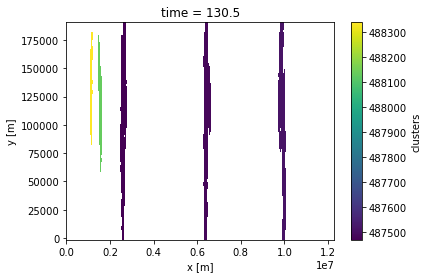

In [9]:
open_set.clusters.isel(time=199).plot()